# Построение и обучение моделей в TensorFlow

В предыдущей лекции был рассмотрен низкоуровневый АПИ TensorFlow. Была построена и обучения модель, используя самые базовые инструменты. В данной лекции будет введен целый ряд новых инструментов в библиотеке TensorFlow, что сильно упрощают построение и обучение моделей. Будут рассмотрены:
1. [tf.data АПИ](https://www.tensorflow.org/guide/data) и в частности tf.data.Dataset - инструменты работы с датасетами;
2. [Keras](https://keras.io/about/) - инструменты для построения и обучения модели.

# 2. Высокоуровневый АПИ + Keras

## 2.1 Датасеты в TensorFlow

Ранее вручную был написан весь код для итерации по датасету. Если придется добавлять какую-либо агументацию данных, то задача сильно усложнится. В данной лекции будет показано, как использовать готовые TensorFlow инструменты при работе с данными.

Ключевой сущностью при работе с датасетами в TensorFlow является [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Создадим датасет из набора Mnist.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

tf.data.Dataset работает как [питоновский генератор](https://skillbox.ru/media/code/generatory_python_chto_eto_takoe_i_zachem_oni_nuzhny/). Попробуем получить один элемент из датасета.

In [4]:
# Получим итератор
data_iter = iter(train_dataset)

# Получим одну пару (картинка, метка)
x, y = next(data_iter)

In [5]:
# Заметьте, что итератор возвратил TensorFlow тензоры, а не Numpy массивы 
x.shape, y.shape, type(x), type(y)

(TensorShape([28, 28]),
 TensorShape([]),
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

tf.data.Dataset имеет множество полезных методов, однако наиболее часто используемые из них:
1. batch(n) - говорит датасету собирать батчи размера `n` вместо итерации по отдельным экземплярам;
2. map(fn) - говорит датасету применять `fn` к элементам датасета;
3. prefetch(n) - говорит датасету постоянно подготавливать `n` элементов в буфере. Это позволяет утилизировать время простоя CPU, когда все вычисления происходят на GPU, что ускоряет загрузку данных;
4. shuffle(n) - говорит датасету создать буффер на `n` элементов, перемешивать его и в дальнейшем черпать элементы из него.

In [6]:
# Вызов методов создаёт новый объект датасета, а не модифицирует исходный!
train_dataset = train_dataset.shuffle(buffer_size=len(x_train), reshuffle_each_iteration=True)

# drop_remainder=True говорит датасету не возвращать оставшийся кусок данных, если в нем содержится меньше 128 элементов
train_dataset = train_dataset.batch(128, drop_remainder=True)

next(iter(train_dataset))[0].shape

TensorShape([128, 28, 28])

In [7]:
def normalize(x, y):
    x = tf.cast(x, dtype='float32')
    x = x / 255.
    return x, y


def reshape(x, y):
    x = tf.reshape(x, shape=[-1, 28*28])
    return x, y

In [8]:
# Трансформации могут применяться параллельно на нескольких элементах!
train_dataset = train_dataset.map(normalize, num_parallel_calls=-1)
train_dataset = train_dataset.map(reshape, num_parallel_calls=-1)
# Говорит датасету всегда иметь на готове 8 батчей
train_dataset = train_dataset.prefetch(8)

next(iter(train_dataset))[0].shape

TensorShape([128, 784])

Метод map можно было вызвать и до метода batch, одна в данном случае функции будут принимать на вход отдельные экземпляры. Это менее эффективно, нежели обработка целых батчей, поскольку в их случае возможно векторизация вычислений.

Некоторые могут задаться вопросом: зачем нормализацию и решейп выводить в отдельные трансформации, что применяются во время итерации по датасету? На практике так действительно не делают, обычно нормализация и прочие трансформации, что можно сделать заранее, делают заранее, дабы не тратить вычислительные ресурсы впустую. Однако в данном случае так сделано, чтобы продемонстрировать работу АПИ.

Далее готовый датасет используют в качестве итератора в цикле. Ниже приведен пример.

In [9]:
EPOCHS = 5
for epoch in range(EPOCHS):
    for x_batch, y_batch in train_dataset:
        # do something 1
        # do something 2
        pass
    print('Epoch:', epoch)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


Цикл заканчивает свою работу после того, как датасет исчерпал все данные. В данном случае после каждой эпохи датасет автоматически производит перемешивание данных.

In [10]:
# Создадим также датасет для тестирования модели
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# drop_remainder в данном случае не установлен, поскольку мы хотим протестировать модель на всех экземплярах данных.
# Почему drop_remainder использовался выше? Опять-таки, для демонстрации, что это есть
test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.map(normalize, num_parallel_calls=-1)
test_dataset = test_dataset.map(reshape, num_parallel_calls=-1)

next(iter(test_dataset))[0].shape

TensorShape([128, 784])

## 2.2 Построение моделей в Keras

Keras представляет собой набор готовых строительных блоков для построения, обучения и профилирования моделей. Существует три подхода к построению моделей в Keras:
1. [Sequential](https://www.tensorflow.org/guide/keras/sequential_model);
2. [Functional](https://www.tensorflow.org/guide/keras/functional);
3. [Наследование от Model](https://www.tensorflow.org/guide/keras/custom_layers_and_models) - рекомендуемый подход!

В данной лекции будет рассмотрен третий подход, поскольку он наиболее универсален и удобен в общем случае. При написании моделей в виде отдельных модулей и классов, код становится куда более читабельным и легко поддерживаемым.

### 2.2.1 Layer

Рассмотрим пример создания слоя в Keras.

In [11]:
import tensorflow.keras as K
import tensorflow.keras.layers as L

In [12]:
class LinearReLU(L.Layer):
    def __init__(self, out_d, name=None):
        super().__init__(name=name)
        self.linear = L.Dense(units=out_d)
        self.relu = L.ReLU()
    
    def call(self, x):
        x = self.linear(x)
        # Можно также использовать и tf.nn.relu
        return self.relu(x)

In [13]:
# Заметьте, что этому слою не нужно предоставлять информацию в размерности входных данных.
# Слои в Keras получат информацию о размерности данных во время первого вызова
linear_relu = LinearReLU(10)

In [14]:
# Весов пока что нет
print(len(linear_relu.variables))

0


In [15]:
# Модули
linear_relu.submodules

(<keras.layers.core.dense.Dense at 0x7fc21013afa0>,
 <keras.layers.advanced_activations.ReLU at 0x7fc21012f0a0>)

In [16]:
# При первом вызове слои инициализируют свои веса, используя информацию
# о размерности входных тензоров.
linear_relu(np.random.randn(1, 10).astype('float32'))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.        , 0.58302677, 0.        , 0.        , 0.        ,
        0.48989415, 0.9036249 , 0.        , 0.30232066, 0.744071  ]],
      dtype=float32)>

In [17]:
# Теперь веса есть.
print(len(linear_relu.variables))

2


### 2.2.1 Model

Построим аналогичную модель, используя Keras

In [18]:
class NN(K.Model):
    def __init__(self, dim=256, n_classes=10, name='neural_network'):
        super().__init__(name=name)
        self.input_layer = L.Dense(units=dim, activation='relu', name='input')
        self.classification_head = L.Dense(units=n_classes)
    
    def call(self, x, training=True):
        x = self.input_layer(x, training=training)
        x = self.classification_head(x, training=training)
        return tf.nn.softmax(x)

В данном случае модель очень простая и не требует написания отдельных слоёв/модулей. Однако в случае более крупных моделей **настоятельно рекомендуется** разбивать их на модули, что наследуются от класса L.Layer, а после скомпоновать их в класс модели. В этом случае другим программистам становится гораздо легче понять, как модель работает, и внести в неё свои изменения.

In [19]:
model = NN()

In [20]:
x = next(iter(train_dataset))[0]

In [21]:
model(x)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[0.06959938, 0.13837601, 0.0652037 , ..., 0.18263756, 0.13797113,
        0.04636167],
       [0.11483506, 0.07217523, 0.07887861, ..., 0.1316258 , 0.11827304,
        0.15272087],
       [0.10576901, 0.1021277 , 0.09075059, ..., 0.14534797, 0.15855393,
        0.05801513],
       ...,
       [0.10754609, 0.06834304, 0.10351732, ..., 0.08484785, 0.15298633,
        0.08085035],
       [0.08990663, 0.07580603, 0.0956449 , ..., 0.07905133, 0.12985934,
        0.18590708],
       [0.08892912, 0.12196412, 0.08968204, ..., 0.10086968, 0.09967561,
        0.09853969]], dtype=float32)>

## 2.3 Обучение моделей в Keras

Обучение моделей в Keras довольно тривиально и сводится к вызову метода fit. Данный метод уже содержит внутри себя реализованную функцию одного обучающего шага (метод train_step), а также обучающий цикл. Пользователю нужно лишь задать функцию ошибки и метрики. Благо Keras уже содержит заранее заготовленные примеры оных:
- [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses);
- [tf.keras.metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).

In [22]:
loss = K.losses.SparseCategoricalCrossentropy()
accuracy = K.metrics.SparseCategoricalAccuracy()
optim = tf.optimizers.Adam()

EPOCHS = 5

In [23]:
model.compile(optimizer=optim, loss=loss, metrics=[accuracy])

In [24]:
info = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset)

Epoch 1/5
468/468 [==============================] - 3s 6ms/step - loss: 0.3104 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.1627 - val_sparse_categorical_accuracy: 0.9535
Epoch 2/5
468/468 [==============================] - 3s 5ms/step - loss: 0.1358 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.1159 - val_sparse_categorical_accuracy: 0.9665
Epoch 3/5
468/468 [==============================] - 2s 5ms/step - loss: 0.0923 - sparse_categorical_accuracy: 0.9730 - val_loss: 0.0886 - val_sparse_categorical_accuracy: 0.9719
Epoch 4/5
468/468 [==============================] - 3s 5ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.0808 - val_sparse_categorical_accuracy: 0.9744
Epoch 5/5
468/468 [==============================] - 3s 5ms/step - loss: 0.0517 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.0744 - val_sparse_categorical_accuracy: 0.9763


Во время обучения Keras показывает информацию о значении функции ошибки и точности на обучающей выборке. Каждую эпоху Keras тестирует модель, вычисляя значение переданных метрик.

Метод .fit возвращает объект с историей обучения, в котором содержатся значения функции ошибки, метрики и т.д.

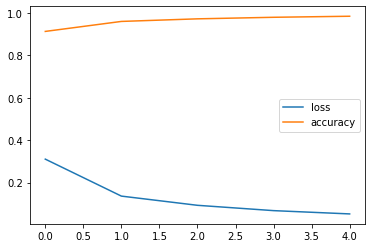

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(info.history['loss'], label='loss')
plt.plot(info.history['sparse_categorical_accuracy'], label='accuracy')
plt.legend()

In [26]:
# Также есть отдельный метод для тестирования
model.evaluate(test_dataset)

79/79 [==============================] - 1s 7ms/step - loss: 0.0744 - sparse_categorical_accuracy: 0.9763


[0.07440932095050812, 0.9763000011444092]

Keras очень сильно абстрагирует код и позволяет сфокусироваться на самой модели и её обучении, опуская детали реализации. Однако при желании можно кастомизировать отдельные компоненты, такие как [шаг обучения или тестирование модели](https://keras.io/guides/customizing_what_happens_in_fit/).

## 2.4 Сохранение моделей в Keras

Сохранение и загрузка моделей в Keras тривиальны.

In [27]:
model.save('keras-model')

INFO:tensorflow:Assets written to: keras-model/assets


In [28]:
model2 = K.models.load_model('keras-model')

In [29]:
model2.evaluate(test_dataset)

79/79 [==============================] - 1s 5ms/step - loss: 0.0744 - sparse_categorical_accuracy: 0.9763


[0.07440954446792603, 0.9763000011444092]